# AtomsToGraph

> Routine to convert ase atom objects to graphs

In [ ]:
#| default_exp AtomsToGraph

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
from ase.io import read, write
from ase import Atoms
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
from torch_geometric.data import InMemoryDataset, Data
from typing import List 
from torch_geometric.nn import radius_graph
from torch_geometric.transforms import OneHotDegree
from sd_playground.basis import GaussianSmearing
from torch_geometric.transforms import Distance
import matplotlib.pyplot as plt

## ASE File IO

Read in an extxyz using ASE's read function

In [ ]:
read_atoms = read("../tests/methane.extxyz")
print(read_atoms)
print(read_atoms.get_positions())
print(read_atoms.get_chemical_symbols())

Atoms(symbols='CH4', pbc=False)
[[ 0.     0.     0.   ]
 [ 0.625  0.625  0.625]
 [-0.625 -0.625  0.625]
 [-0.625  0.625 -0.625]
 [ 0.625 -0.625 -0.625]]
['C', 'H', 'H', 'H', 'H']


In [ ]:
#| hide
atom_symbols = ["C", "H", "H", "H", "H"]
coords = [[0.000, 0.000, 0.000],
          [0.625, 0.625, 0.625],
          [-0.625, -0.625, 0.625],
          [-0.625, 0.625, -0.625],
          [0.625, -0.625, -0.625]]
atoms = Atoms(atom_symbols, coords)
test_eq(read_atoms.get_positions(), atoms.get_positions())
test_eq(read_atoms.get_chemical_symbols(), atoms.get_chemical_symbols())
print(atoms.get_all_distances())

[[0.         1.08253175 1.08253175 1.08253175 1.08253175]
 [1.08253175 0.         1.76776695 1.76776695 1.76776695]
 [1.08253175 1.76776695 0.         1.76776695 1.76776695]
 [1.08253175 1.76776695 1.76776695 0.         1.76776695]
 [1.08253175 1.76776695 1.76776695 1.76776695 0.        ]]


In [ ]:
#| export
class OneHotAtomSymbols:
    """
    Generate one-hot features for a list of atom symbols.
    """
    def __init__(self, symbols: list, # atom symbols
                 ) -> np.ndarray: # [M, N] where M is the number of atoms, and N is the number of unique atom symbols
        symbols = np.array(symbols).reshape(-1, 1) # Convert List to 2D array with N rows and 1 column
        enc = OneHotEncoder(sparse_output=False)
        self.enc = enc.fit(symbols) # Creates one-hot encoder with N rows and M unique elments for the columns
    
    def __call__(self, 
                 symbols: list
                 ) -> np.ndarray:
        return self.enc.transform(np.array(symbols).reshape(-1, 1))

## One Hot Encoding

Instead of atom symbols, we use one hot encoding to discretize atom types

In [ ]:
one_hot_features = OneHotAtomSymbols(atom_symbols)
one_hot_features(atom_symbols)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
#| hide
methane_onehot = np.array([[1., 0.], [0., 1.], [0., 1.], [0., 1.], [0., 1.]])
one_hot_features = OneHotAtomSymbols(atom_symbols)
test_eq(one_hot_features(atom_symbols), methane_onehot)

In [ ]:
#| hide
read_atoms = [read_atoms, read_atoms]

In [ ]:
#| export

class ScoreDynamicsDataset(InMemoryDataset):
    def __init__(self,
                 root, # folder where the dataset should be stored. Splits into raw_dir and processed_dir
                 cutoff=5.0, # cutoff radius for the neighbor list
                 max_num_neighbors=50, # maximum number of neighbors for each atom
                 transform=None, # dynamically transforms the data object before accessing (e.g. data augmentation)
                 pre_transform=None, # applices transformation before saving to disk (e.g. best used for heavy precomputations)
                 pre_filter=None # filter out data objects before saving to disk
                 ):
         self.cutoff = cutoff
         self.max_num_neighbors = max_num_neighbors
         super().__init__(root, transform, pre_transform, pre_filter)
         self.load(self.processed_paths[0])
    
    @property
    def raw_file_names(self):
        return ["data.extxyz"]

    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def process(self):
        gaussian_basis = GaussianSmearing()
        atoms = read(self.raw_paths[0], index=":")
        data_list = []
        all_unique_atoms = []
        for i in range(len(atoms)):
            data = Data()
            data["x"] = torch.Tensor(atoms[i].get_atomic_numbers())
            data["symbols"] = atoms[i].get_chemical_symbols()
            # data["num_nodes"] = atoms[i].get_global_number_of_atoms()
            data["pos"] = torch.Tensor(read_atoms[i].get_positions())
            
            # Connectivity
            data["edge_index"] = radius_graph(data["pos"], r=self.cutoff, batch=None, loop=True, max_num_neighbors=self.max_num_neighbors)

            # Convert distances to edge features            
            distances = Distance(norm=False, cat=False)(data)["edge_attr"]
            data["edge_attr"] = gaussian_basis(distances).squeeze(1) # squeeze removes singleton dimension

            data["y"] = []
            data["structure_id"] = i
            data_list.append(data)

            unique_atoms = list(set(read_atoms[i].get_chemical_symbols()))
            for atom in unique_atoms:
                if atom not in all_unique_atoms:
                    all_unique_atoms.append(atom)

        # Conver Atomic Numbers to One-Hot Features
        self.unique_atoms = all_unique_atoms
        one_hot_features = OneHotAtomSymbols(self.unique_atoms)
        for data in data_list:
            data["x"] = one_hot_features(data["symbols"])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

## Create InMemory dataset

In order to create an `ScoreDynamicsDataset`, one needs to set up a data directory with two subdirectores: raw and processed. Inside raw, place the ase .extxyz file called "data.extxyz". Then pass that data directory to the `ScoreDynamicsDataset`. Torch-Geometric Handles the rest  

In [ ]:
!rm ../data_path/processed/*

In [ ]:
dataset = ScoreDynamicsDataset(root="../data_path")

Processing...
Done!


In [ ]:
dataset[0].edge_attr.shape[0]

25

Text(0.5, 1.0, 'Gaussian Basis Functions For Methane Distances')

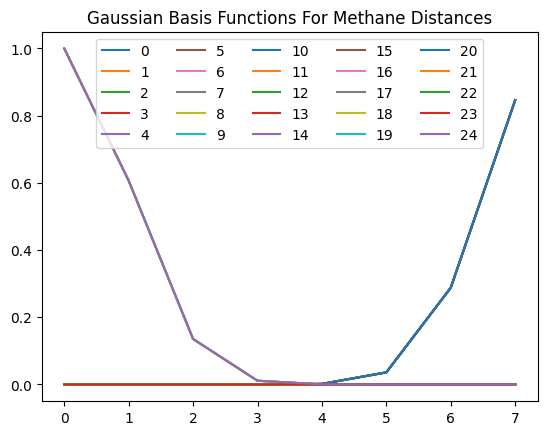

In [ ]:
fig, ax = plt.subplots()
for i in range(dataset[0].edge_attr.shape[0]):
    ax.plot(dataset[0].edge_attr[i,:].numpy(), label=f"{i}")
ax.legend(ncol=5)
ax.set_title("Gaussian Basis Functions For Methane Distances")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()